<a href="https://colab.research.google.com/github/lijovi/Flower-Classification/blob/main/comvis_final_random_forest_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os

In [ ]:
with zipfile.ZipFile('DATASET_COMVIS.zip', 'r') as zip_ref:
    zip_ref.extractall('Dataset_CV')

In [ ]:
Data_train = './Dataset_CV/DATASET_COMVIS/train'
Data_test = './Dataset_CV/DATASET_COMVIS/test'
Data_val = './Dataset_CV/DATASET_COMVIS/val'

In [ ]:
def crop(input):
  img = cv2.imread(input)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  if contours:
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    new_img = img[y:y + h, x:x + w]
    # Hitung koordinat crop baru untuk memastikan bunga di tengah
    # Sesuaikan rasio aspek jika diperlukan
    crop_x = max(0, x - (w // 2))
    crop_y = max(0, y - (h // 2))
    new_img = img[crop_y:crop_y + h, crop_x:crop_x + w]
  else:
    # Handle case where no contours are found, e.g., use original image
    new_img = img
  # img = np.array(new_img)
  return img

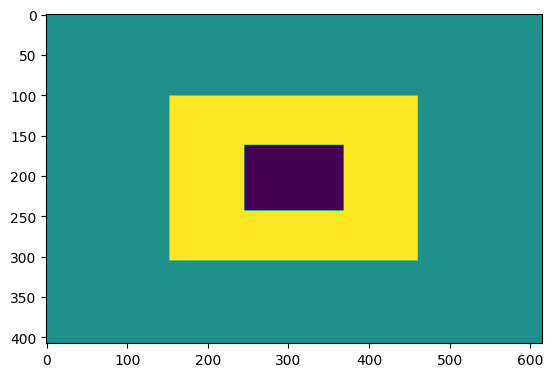

In [ ]:
def init_grabcut_mask(h, w):
  mask = np.ones((h, w), np.uint8) * cv2.GC_PR_BGD
  mask[h//4:3*h//4, w//4:3*w//4] = cv2.GC_PR_FGD
  mask[2*h//5:3*h//5, 2*w//5:3*w//5] = cv2.GC_FGD
  return mask

plt.imshow(init_grabcut_mask(3*136, 3*205))

In [ ]:
def add_contours(image, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours) != 0:
        cv2.drawContours(image, contours, -1, (255, 0, 0), 3)
        c = max(contours, key = cv2.contourArea)
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0) ,2)

In [ ]:
def remove_background2(image):
  # image = eHist(image)
  h, w = image.shape[:2]
  mask = init_grabcut_mask(h, w)
  bgm = np.zeros((1, 65), np.float64)
  fgm = np.zeros((1, 65), np.float64)
  cv2.grabCut(image, mask, None, bgm, fgm, 1, cv2.GC_INIT_WITH_MASK)
  mask_binary = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
  result = cv2.bitwise_and(image, image, mask = mask_binary)
  # Terapkan Otsu Thresholding
  # gray_image = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
  # _, otsu_mask = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  # # Gabungkan hasil GrabCut dan Otsu
  # combined_mask = cv2.bitwise_and(mask_binary, otsu_mask // 255)  # Ubah otsu_mask menjadi 0 dan 1
  # final_result = cv2.bitwise_and(image, image, mask=combined_mask)

  # # Tambahkan kontur (opsional)
  # add_contours(final_result, combined_mask)

  # return final_result
  add_contours(result, mask_binary) # optional, adds visualizations
  # result = cv2.GaussianBlur(result, (3,3), 0)
  # result = eHist(result)
  return result

In [ ]:
def eHist(img):
  b, g, r = cv2.split(img)

  # Apply histogram equalization to each channel
  equalized_b = cv2.equalizeHist(b)
  equalized_g = cv2.equalizeHist(g)
  equalized_r = cv2.equalizeHist(r)

  # Merge the equalized channels back into a single image
  equalized_image = cv2.merge((equalized_b, equalized_g, equalized_r))

  # Optional: Apply a colormap (e.g., COLORMAP_JET)
  # colored_image = cv2.applyColorMap(equalized_image, cv2.COLORMAP_JET)

  return equalized_image

In [ ]:
from skimage.feature import hog
from skimage.feature import graycomatrix, graycoprops

def extract_features2(img):

    # Convert the image from RGBA to BGR
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)

    # Konversi ke HSV
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # Hitung histogram warna
    hist = cv2.calcHist([hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])

    # Konversi ke grayscale untuk deteksi tepi
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    # gray = cv2.GaussianBlur(gray, (3,3), 0)
    # gray= cv2.equalizeHist(gray)
    gray = gray.astype(np.uint8)

    # Deteksi tepi dan temukan kontur
    edges = cv2.Canny(gray, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Handle case where no contours are found to avoid index error.
    if len(contours) > 0:
        cnt = max(contours, key=cv2.contourArea)
    else:
        # create a single contour using the image dimensions as a fallback
        cnt = np.array([[[0, 0]], [[img.shape[1] - 1, 0]],
                         [[img.shape[1] - 1, img.shape[0] - 1]],
                         [[0, img.shape[0] - 1]]], dtype=np.int32)

    # Hitung momen invariante Hu
    moments = cv2.moments(cnt)
    hu_moments = cv2.HuMoments(moments)

    # Hitung Histogram of Oriented Gradients (HOG)
    hog_features = hog(gray, orientations=8, pixels_per_cell=(16, 16),
                       cells_per_block=(2, 2), block_norm='L2')

    # Hitung GLCM
    glcm = graycomatrix(gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                       levels=256, symmetric=True, normed=True)

    # Ekstrak fitur dari GLCM
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    entropy = -np.sum(glcm * np.log(glcm + 1e-10))
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    # Gabungkan semua fitur
    features = np.concatenate((hist.flatten(), hu_moments.flatten(), hog_features,
                               [contrast, entropy, dissimilarity, homogeneity, energy, correlation]))

    return features

In [ ]:
label_list=['bluebell', 'buttercup', 'cowslip', 'crocus', 'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris', 'pansy', 'rose','snowdrop', 'sunflower', 'tiger lily', 'tulip', 'windflower']

In [ ]:
def preprosses(data_dir, label_list, resize_shape=(500, 500)):

    features = []
    labels = []

    for label_idx, label in enumerate(label_list):
        class_dir = os.path.join(data_dir, label)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            img = cv2.imread(img_path)
            # img = crop(img_path)
            # img = remove_background2(img)
            img = cv2.resize(img, resize_shape)
            descriptors = extract_features2(img)  # Assuming extract_features2 is defined elsewhere

            if descriptors is not None and descriptors.size > 0:
                features.append(descriptors)
                labels.append(label_idx)
            else:
                print(f"Warning: Skipping image {img_path} due to empty or invalid descriptors.")

    return np.array(features), np.array(labels)


In [ ]:
# Extract features and labels for each dataset
X_train, y_train = preprosses(Data_train, label_list)
X_val, y_val = preprosses(Data_val, label_list)
X_test, y_test = preprosses(Data_test, label_list)

print("Shape of features array (Train):", X_train.shape)
print("Shape of features array (Val):", X_val.shape)
print("Shape of features array (Test):", X_test.shape)

Shape of features array (Train): (1088, 74893)
Shape of features array (Val): (135, 74893)
Shape of features array (Test): (137, 74893)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve, validation_curve
import seaborn as sns
import tensorflow as tf
import pandas as pd

In [ ]:
# Misalkan features adalah array dari deskriptor dan labels adalah array dari nama bunga
# X_train, X_test, y_train, y_test = train_test_split(features, class_list, test_size=0.2, random_state=42)


In [ ]:
train_scores_c, test_scores_c = validation_curve(
    RandomForestClassifier(), X_train, y_train, param_name='n_estimators', param_range=np.arange(0, 250, 5), cv=5, scoring='accuracy'
)

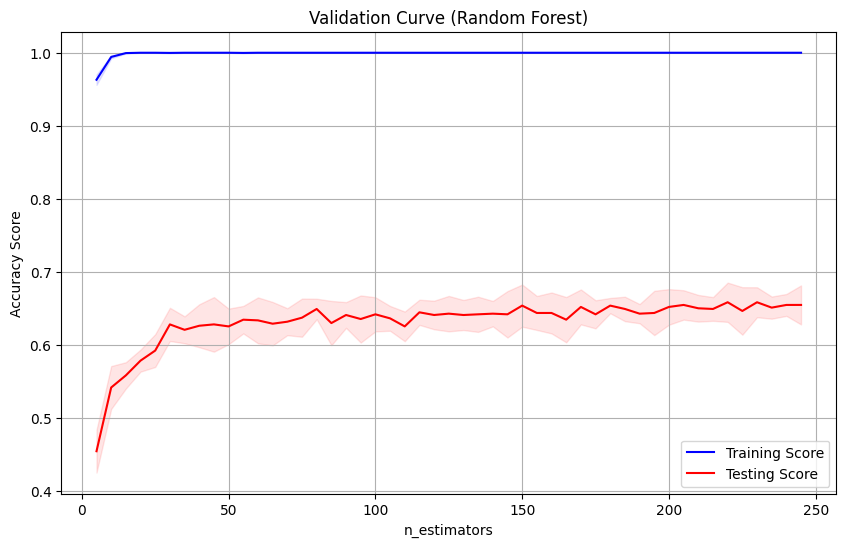

In [ ]:
train_mean_c = np.mean(train_scores_c, axis=1)
train_std_c = np.std(train_scores_c, axis=1)
test_mean_c = np.mean(test_scores_c, axis=1)
test_std_c= np.std(test_scores_c, axis=1)
param_range = np.arange(0, 250, 5)
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean_c, label='Training Score', color='b')
plt.fill_between(param_range, train_mean_c - train_std_c, train_mean_c + train_std_c, alpha=0.1, color='b')
plt.plot(param_range, test_mean_c, label='Testing Score', color='r')
plt.fill_between(param_range, test_mean_c - test_std_c, test_mean_c + test_std_c, alpha=0.1, color='r')
plt.title('Validation Curve (Random Forest)')
plt.xlabel('n_estimators')  # Replace with the hyperparameter name
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
print(f"The average train accuracy is {train_scores_c.mean():.2f}")
print(f"The average test accuracy is {test_scores_c.mean():.2f}")
for i in range(len(param_range)):
  print(f"n_estimators: {param_range[i]}")
  print(f"train score: {train_mean_c[i]}")
  print(f"test score: {test_mean_c[i]}")


The average train accuracy is nan
The average test accuracy is nan
n_estimators: 0
train score: nan
test score: nan
n_estimators: 5
train score: 0.9630061892130858
test score: 0.4539889231809918
n_estimators: 10
train score: 0.9942560407511515
test score: 0.5413182260178414
n_estimators: 15
train score: 0.9995404938173852
test score: 0.5579123155625079
n_estimators: 20
train score: 1.0
test score: 0.5781380797361857
n_estimators: 25
train score: 1.0
test score: 0.5919037754196085
n_estimators: 30
train score: 0.9997701149425288
test score: 0.6277723755971759
n_estimators: 35
train score: 1.0
test score: 0.6203737369466875
n_estimators: 40
train score: 1.0
test score: 0.6259163742442819
n_estimators: 45
train score: 1.0
test score: 0.627789286771234
n_estimators: 50
train score: 1.0
test score: 0.6250243098127088
n_estimators: 55
train score: 0.9997701149425288
test score: 0.634219760706887
n_estimators: 60
train score: 1.0
test score: 0.6333065573077411
n_estimators: 65
train score: 1.

In [ ]:
#Feature importance using RF
rf_classifier = RandomForestClassifier(n_estimators=220, random_state=42)
rf_classifier.fit(X_train, y_train)
importances = rf_classifier.feature_importances_
# Membuat DataFrame untuk melihat skor kepentingan
feature_names = range(X_train.shape[1])
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Mengurutkan berdasarkan skor kepentingan secara descending
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Mengambil 10000 fitur teratas
top_10000_features = feature_importances.head(10000)['feature'].tolist()

# Membuat dataset baru dengan hanya 10000 fitur teratas
X_train_rf = X_train[:, top_10000_features]
X_val_rf = X_val[:, top_10000_features]
X_test_rf = X_test[:, top_10000_features]

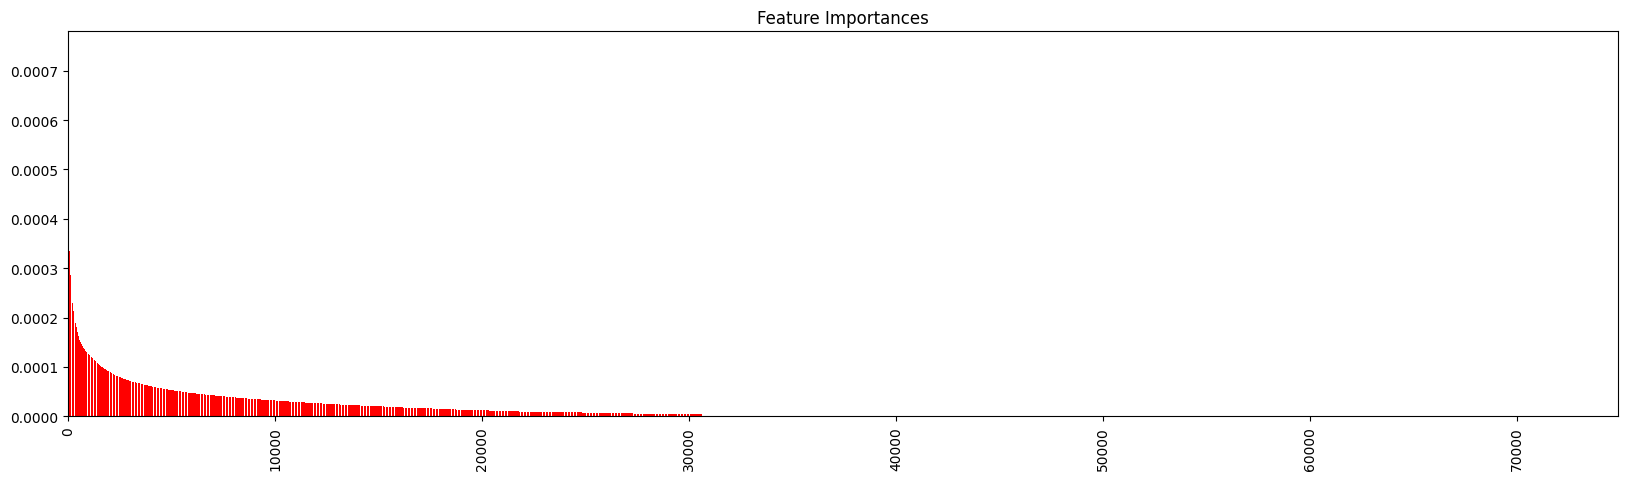

In [ ]:
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(20,5))
plt.title("Feature Importances")
plt.bar(feature_names, importances[indices],
       color="r", align="center")
plt.xticks(rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
X_train_rf.shape

(1088, 10000)

In [ ]:
train_scores_b, test_scores_b = validation_curve(
    RandomForestClassifier(), X_train_rf, y_train, param_name='n_estimators', param_range=np.arange(0, 250, 5), cv=5, scoring='accuracy'
)

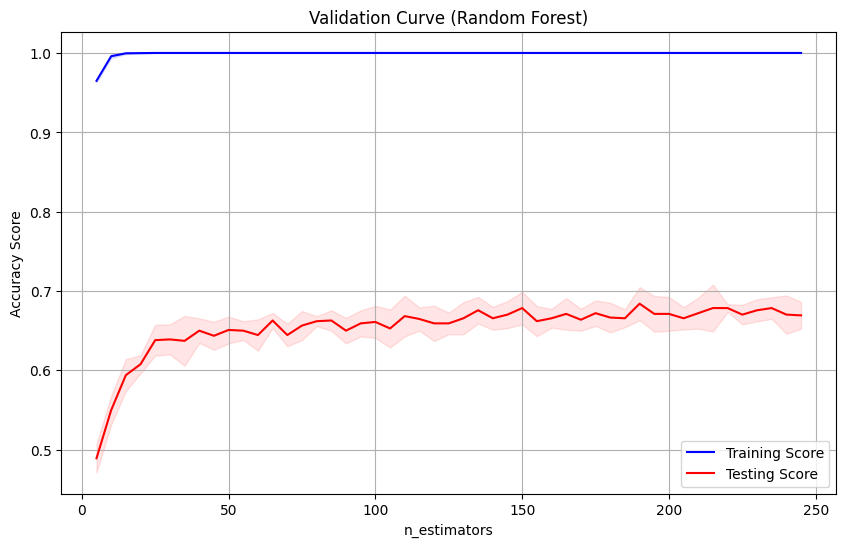

In [ ]:
train_mean_b = np.mean(train_scores_b, axis=1)
train_std_b = np.std(train_scores_b, axis=1)
test_mean_b = np.mean(test_scores_b, axis=1)
test_std_b = np.std(test_scores_b, axis=1)
param_range = np.arange(0, 250, 5)
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean_b, label='Training Score', color='b')
plt.fill_between(param_range, train_mean_b - train_std_b, train_mean_b + train_std_b, alpha=0.1, color='b')
plt.plot(param_range, test_mean_b, label='Testing Score', color='r')
plt.fill_between(param_range, test_mean_b - test_std_b, test_mean_b + test_std_b, alpha=0.1, color='r')
plt.title('Validation Curve (Random Forest)')
plt.xlabel('n_estimators')  # Replace with the hyperparameter name
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
print(f"The average train accuracy is {train_scores_b.mean():.2f}")
print(f"The average test accuracy is {test_scores_b.mean():.2f}")
for i in range(len(param_range)):
  print(f"n_estimators: {param_range[i]}")
  print(f"train score: {train_mean_b[i]}")
  print(f"test score: {test_mean_b[i]}")


The average train accuracy is nan
The average test accuracy is nan
n_estimators: 0
train score: nan
test score: nan
n_estimators: 5
train score: 0.9648447418082003
test score: 0.4889612311334714
n_estimators: 10
train score: 0.9958631246948281
test score: 0.5496596626220775
n_estimators: 15
train score: 0.999540757749713
test score: 0.5937724601530461
n_estimators: 20
train score: 0.9997701149425288
test score: 0.6075170168688963
n_estimators: 25
train score: 1.0
test score: 0.6378852576840147
n_estimators: 30
train score: 1.0
test score: 0.6388238278442481
n_estimators: 35
train score: 1.0
test score: 0.6369931932524416
n_estimators: 40
train score: 1.0
test score: 0.6498118631886018
n_estimators: 45
train score: 1.0
test score: 0.6433940726334926
n_estimators: 50
train score: 1.0
test score: 0.6507335221747771
n_estimators: 55
train score: 1.0
test score: 0.6498372299496893
n_estimators: 60
train score: 1.0
test score: 0.6443284150002114
n_estimators: 65
train score: 1.0
test score: 

In [ ]:
rf = RandomForestClassifier(n_estimators=190, random_state=42)
rf.fit(X_train_rf, y_train)

y_pred_val = rf.predict(X_val_rf)
y_pred_test = rf.predict(X_test_rf)

# Langkah 3: Hitung akurasi
accuracy = accuracy_score(y_val, y_pred_val)
print(f'Akurasi validation model rf: {accuracy * 100:.2f}%')

report = classification_report(y_val, y_pred_val)
print('Classification Report:\n', report)

# Langkah 3: Hitung akurasi
accuracy = accuracy_score(y_test, y_pred_test)
print(f'Akurasi testing model rf: {accuracy * 100:.2f}%')

report = classification_report(y_test, y_pred_test)
print('Classification Report:\n', report)



Akurasi validation model rf: 67.41%
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.83      0.62      0.71         8
           2       0.45      0.62      0.53         8
           3       1.00      0.50      0.67         8
           4       0.60      0.75      0.67         8
           5       1.00      0.88      0.93         8
           6       0.67      0.50      0.57         8
           7       0.78      0.88      0.82         8
           8       1.00      0.50      0.67         8
           9       0.83      0.62      0.71         8
          10       0.75      0.38      0.50         8
          11       0.50      1.00      0.67        16
          12       0.75      0.86      0.80         7
          13       0.67      0.75      0.71         8
          14       0.67      0.25      0.36         8
          15       0.71      0.62      0.67         8

    accuracy        

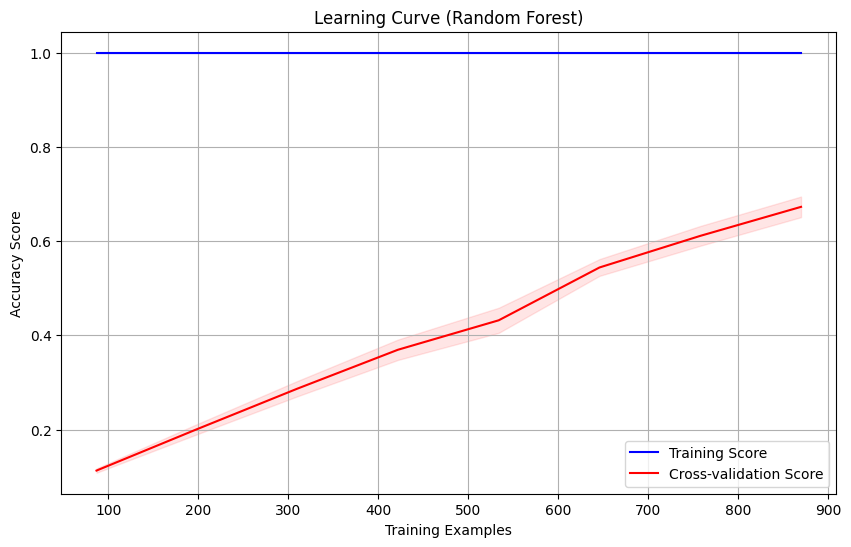

In [ ]:
train_sizes_a, train_scores_a, test_scores_a = learning_curve(
    rf, X_train_rf, y_train, train_sizes=np.linspace(0.1, 1.0, 8), cv=5, scoring='accuracy')

train_mean_a = np.mean(train_scores_a, axis=1)
train_std_a = np.std(train_scores_a, axis=1)
test_mean_a = np.mean(test_scores_a, axis=1)
test_std_a = np.std(test_scores_a, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes_a, train_mean_a, label='Training Score', color='b')
plt.fill_between(train_sizes_a, train_mean_a - train_std_a, train_mean_a + train_std_a, alpha=0.1, color='b')
plt.plot(train_sizes_a, test_mean_a, label='Cross-validation Score', color='r')
plt.fill_between(train_sizes_a, test_mean_a - test_std_a, test_mean_a + test_std_a, alpha=0.1, color='r')
plt.title('Learning Curve (Random Forest)')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
print(f"The average train accuracy is {train_scores_a.mean():.2f}")
print(f"The average test accuracy is {test_scores_a.mean():.2f}")
for i in range(len(train_sizes_a)):
  print(f"data size: {train_sizes_a[i]}")
  print(f"train score: {train_mean_a[i]}")
  print(f"test score: {test_mean_a[i]}")

The average train accuracy is 1.00
The average test accuracy is 0.40
data size: 87
train score: 1.0
test score: 0.11304697078594683
data size: 198
train score: 1.0
test score: 0.2003720458292817
data size: 310
train score: 1.0
test score: 0.2867627785058978
data size: 422
train score: 1.0
test score: 0.36949646979241535
data size: 534
train score: 1.0
test score: 0.4320170802857988
data size: 646
train score: 1.0
test score: 0.5441423920855705
data size: 758
train score: 1.0
test score: 0.611237475161713
data size: 870
train score: 1.0
test score: 0.672840654462436


Validation Curve: Untuk memilih nilai hiperparameter terbaik.
Learning Curve: Untuk mengevaluasi apakah model mengalami underfitting atau overfitting.
F1-Score: Untuk mengevaluasi kinerja model secara keseluruhan, terutama pada kasus ketidakseimbangan kelas.

Text(0.5, 1.0, 'Confusion Matrix Data Validation')

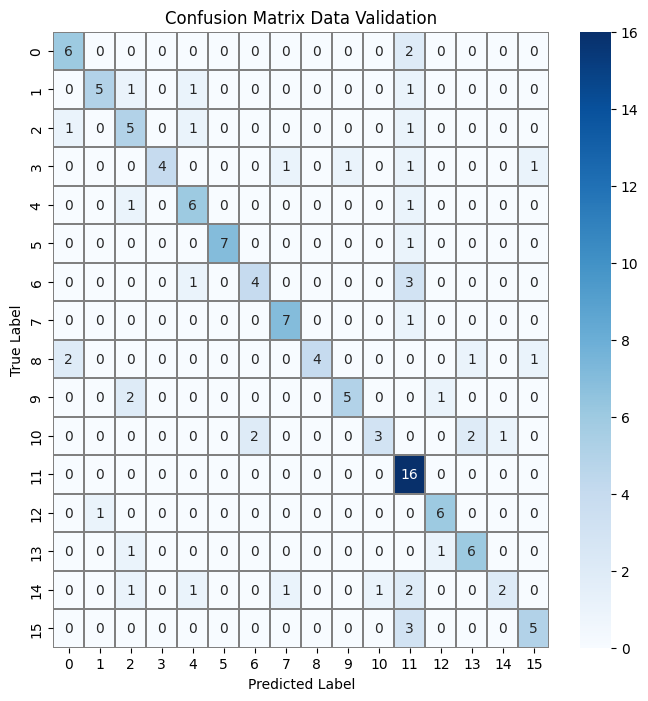

In [ ]:
cm = confusion_matrix(y_val, y_pred_val)
f,ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap="Blues", linecolor="gray", fmt= 'd',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Data Validation")

Text(0.5, 1.0, 'Confusion Matrix Data Testing')

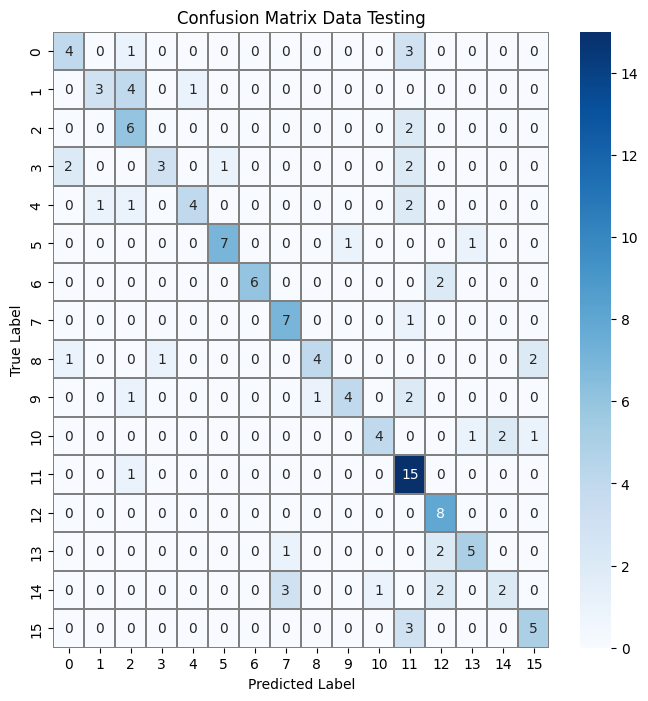

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
f,ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap="Blues", linecolor="gray", fmt= 'd',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Data Testing")

In [ ]:
def classify_flower(image_path):
  # img = cv2.imread(image_path)
  img = crop(image_path)
  img = remove_background2(img)
  # img= change_background(img)
  img = cv2.resize(img, (500,500))
  # img = cv2.imread(image_path)
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  features = extract_features2(img)
  print(features.shape)
  features_rf = features[top_10000_features]
  print(features_rf.shape)
  prediction = rf.predict(features_rf.reshape(1, -1))  # Ubah bentuk fitur jika perlu
  return prediction[0]  # Kembalikan nama bunga yang diprediksi

In [ ]:
for i in np.random.choice(10, size=10, replace=False):
    prediction = rf.predict(X_test_rf[i].reshape(1, -1))
    print(f"Prediksi bunga: {label_list[prediction[0]]}, label: {label_list[y_test[i]]}")

Prediksi bunga: snowdrop, label: bluebell
Prediksi bunga: buttercup, label: buttercup
Prediksi bunga: snowdrop, label: bluebell
Prediksi bunga: bluebell, label: bluebell
Prediksi bunga: cowslip, label: buttercup
Prediksi bunga: bluebell, label: bluebell
Prediksi bunga: cowslip, label: bluebell
Prediksi bunga: bluebell, label: bluebell
Prediksi bunga: bluebell, label: bluebell
Prediksi bunga: snowdrop, label: bluebell


In [ ]:
for i in range(9):
  prediction = rf.predict(X_train_rf[i].reshape(1, -1))
  print(f"Prediksi bunga: {label_list[prediction[0]]}, label: {label_list[y_train[i]]}")

Prediksi bunga: bluebell, label: bluebell
Prediksi bunga: bluebell, label: bluebell
Prediksi bunga: bluebell, label: bluebell
Prediksi bunga: bluebell, label: bluebell
Prediksi bunga: bluebell, label: bluebell
Prediksi bunga: bluebell, label: bluebell
Prediksi bunga: bluebell, label: bluebell
Prediksi bunga: bluebell, label: bluebell
Prediksi bunga: bluebell, label: bluebell


(74893,)
(10000,)
(74893,)
(10000,)
Prediksi bunga: snowdrop


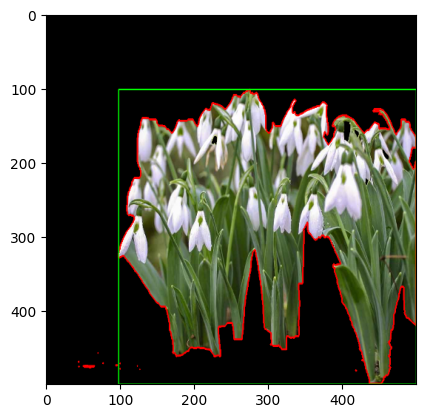

In [ ]:
path = '/content/snowdrop.jpg'
classify_flower(path)
print(f"Prediksi bunga: {label_list[classify_flower(path)]}")

(74893,)
(10000,)
(74893,)
(10000,)
Prediksi bunga: daffodil


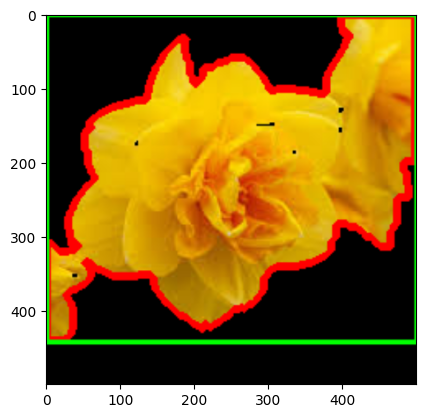

In [ ]:
path = '/content/dafodil.jpeg'
classify_flower(path)
print(f"Prediksi bunga: {label_list[classify_flower(path)]}")

(74893,)
(10000,)
(74893,)
(10000,)
Prediksi bunga: sunflower


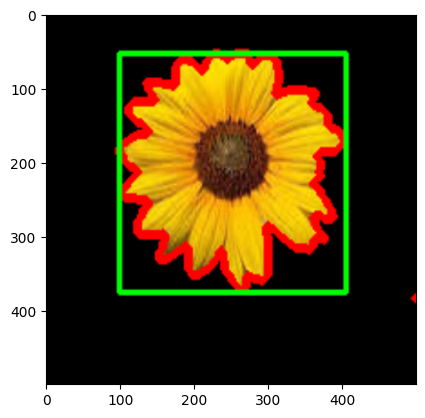

In [ ]:
path = '/content/sunflower.jpg'
classify_flower(path)
print(f"Prediksi bunga: {label_list[classify_flower(path)]}")

(74893,)
(10000,)
(74893,)
(10000,)
Prediksi bunga: rose


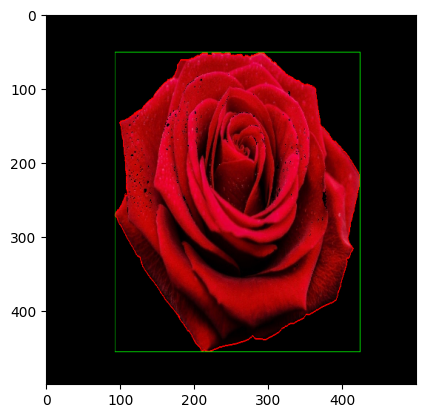

In [ ]:
path = '/content/rose.jpg'
classify_flower(path)
print(f"Prediksi bunga: {label_list[classify_flower(path)]}")

(74893,)
(10000,)
(74893,)
(10000,)
Prediksi bunga: crocus


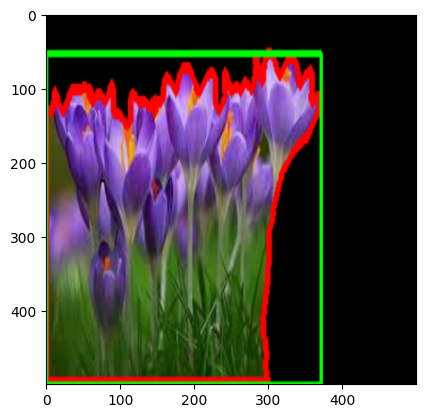

In [ ]:
path = '/content/crocus.jpg'
classify_flower(path)
print(f"Prediksi bunga: {label_list[classify_flower(path)]}")